# Objective  : Histopathologic Cancer Detection
### Submitted by 
   * CHANDAN SAGAR RANA   (M22PH006)
   * TUSHAR TIRTHA SARMAH (M22ME058)
   * Aditya Gupta         (M22MT006)

We have taken a famous **PCam** dataset for the purpose.  In this dataset, we are provided with a large number of small pathology images to classify. We're provided with train ,test and labels data files. Files are named with an image id. A positive label indicates that the center **32x32px** region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.


### Importing the necessary libraries

In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [2]:
data_train_path = "D:\\IIT JODHPUR\\JUPYTER WORK\\FML\\Class lab\\PROJECT\\train"
data_test_path = "D:\\IIT JODHPUR\\JUPYTER WORK\\FML\\Class lab\\PROJECT\\test"
data_train_labels = pd.read_csv("D:\\IIT JODHPUR\\JUPYTER WORK\\FML\\Class lab\\PROJECT\\train_labels\\train_labels.csv")

### Creating the dataframe and merging the labels from the folder

In [3]:
tif_files = [os.path.join(data_train_path, filename) for filename in os.listdir(data_train_path)
             if filename.endswith('.tif')]
df = pd.DataFrame({'path': tif_files})
#print(df.head())
#df['path'][0]
df['id'] = df['path'].map(lambda x: x.split('\\')[7].split(".")[0]) 
#df['id'][0]
#df.head(5)
df = df.merge(data_train_labels, on = "id") # merged labels and filepaths
df.head(10)

,path,id,label
0,D:\IIT JODHPUR\JUPYTER WORK\FML\Class lab\PROJ...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,D:\IIT JODHPUR\JUPYTER WORK\FML\Class lab\PROJ...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,D:\IIT JODHPUR\JUPYTER WORK\FML\Class lab\PROJ...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,D:\IIT JODHPUR\JUPYTER WORK\FML\Class lab\PROJ...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,D:\IIT JODHPUR\JUPYTER WORK\FML\Class lab\PROJ...,0000da768d06b879e5754c43e2298ce48726f722,1
5,D:\IIT JODHPUR\JUPYTER WORK\FML\Class lab\PROJ...,0000f8a4da4c286eee5cf1b0d2ab82f979989f7b,0
6,D:\IIT JODHPUR\JUPYTER WORK\FML\Class lab\PROJ...,00010f78ea8f878117500c445a658e5857f4e304,0
7,D:\IIT JODHPUR\JUPYTER WORK\FML\Class lab\PROJ...,00011545a495817817c6943583b294c900a137b8,0
8,D:\IIT JODHPUR\JUPYTER WORK\FML\Class lab\PROJ...,000126ec42770c7568204e2f6e07eb9a07d5e121,0
9,D:\IIT JODHPUR\JUPYTER WORK\FML\Class lab\PROJ...,00014e39b5df5f80df56f18a0a049d1cc6de430a,1


Due to limited computational power, we had to cut down files to 50,000 images.

In [4]:
def load_data(N, df):
    """ This function loads N images using the data df """
    X = np.zeros([N, 96, 96, 3], dtype=np.uint8)                  # 3 inputs suggest the files are of RGB type
    y = np.squeeze(df['label'].values)[:N]

    for i in range(N):
        X[i] = cv2.imread(df['path'][i])

    return X, y

In [5]:
N = 50000
x,y = load_data(N,df)

50000
50000


Normalization for values to lie under 0-1 scale

In [7]:
x = x / 255.0  # maximum pixel values

Generating 8 random samples with labels and plotting them

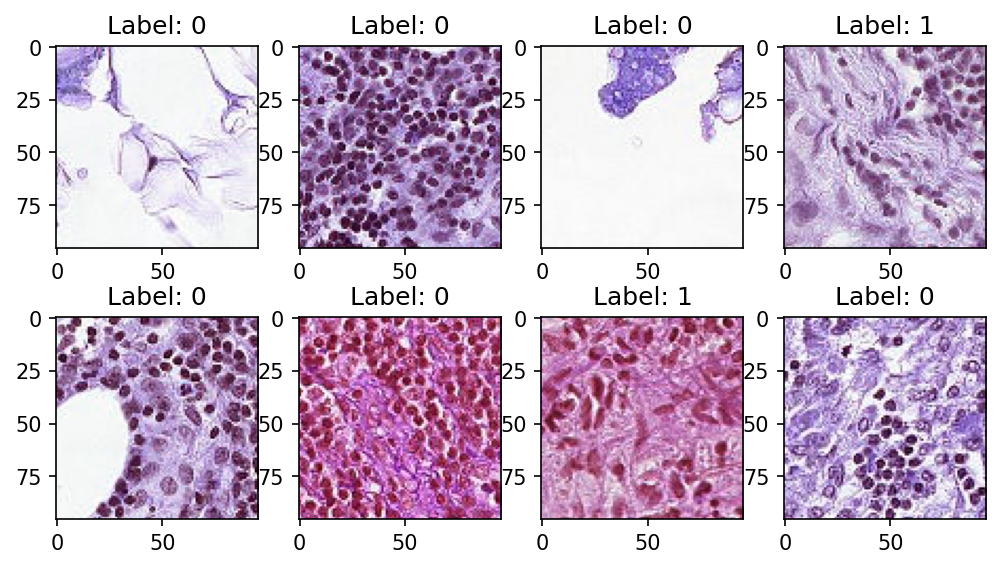

In [8]:
fig = plt.figure(figsize=(8, 9), dpi=150)
np.random.seed(100) 
image_count = 8  # number of images we want to have

for plot_idx, image_idx in enumerate(np.random.randint(0, N, image_count)):
    ax = fig.add_subplot(4, 4, plot_idx+1)
    plt.imshow(x[image_idx])
    ax.set_title("Label: " + str(y[image_idx]))

Checking the count plot to check whether the data is balanced or not since we had to cut down few files

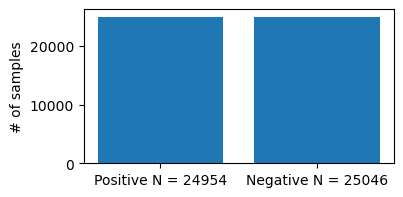

In [9]:
fig = plt.figure(figsize=(4, 2),dpi=100)
number_of_negatives = (y==0).sum()
number_of_positives = (y==1).sum()
negative_samples = x[y==0]
positive_samples = x[y==1]
plt.bar([1, 0], [number_of_negatives, number_of_positives])
plt.xticks([1, 0], ["Negative N = " + str(number_of_negatives), 
                    "Positive N = " + str(number_of_positives)])
plt.ylabel("# of samples");

We plot subplots to visualize histograms of pixel values in image color channels (Red, Green, Blue) and cumulative RGB for both positive and negative samples. This analysis aids in understanding the distribution of pixel intensities across color channels and distinguishes patterns between positive and negative samples in the dataset.

Text(0.5, 1.0, 'Negative Samples')

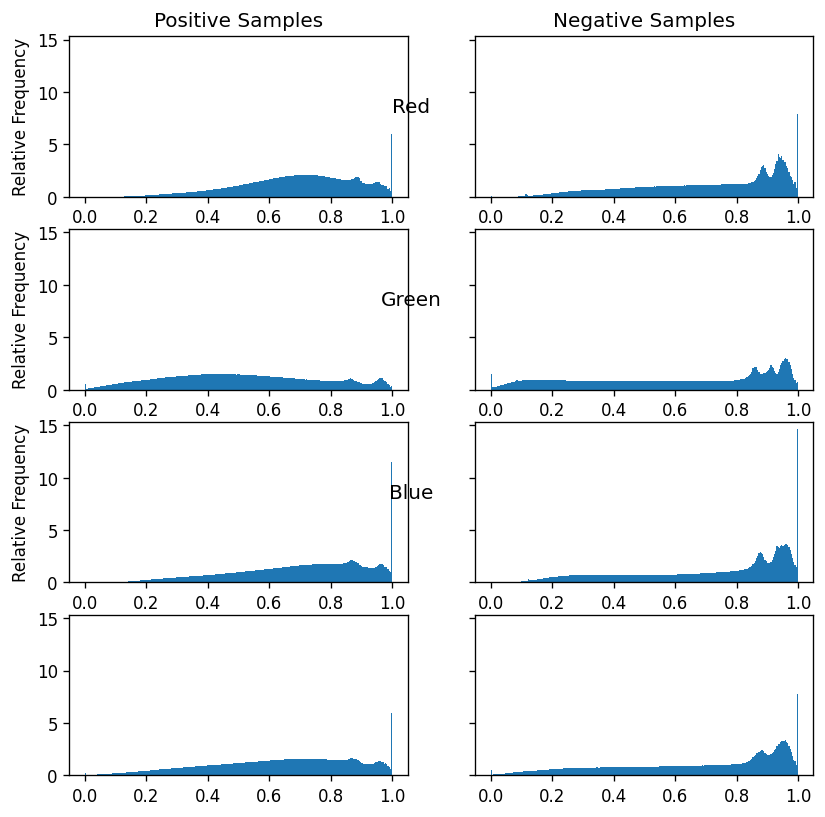

In [10]:
nr_of_bins = 256 
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=120)  
rgb_list = ["Red", "Green", "Blue", "RGB"]

for row_idx in range(0, 4):
    for col_idx in range(0, 2):
        if row_idx < 3:
            axs[row_idx, 0].set_ylabel("Relative Frequency")
            axs[row_idx, 1].set_ylabel(rgb_list[row_idx], rotation="horizontal",
                                       labelpad=35, fontsize=12)

            if col_idx == 0: 
                axs[row_idx, 0].hist(positive_samples[:, :, :, row_idx].flatten(),
                                     bins=nr_of_bins, density = True)
            elif col_idx == 1: 
                axs[row_idx, 1].hist(negative_samples[:, :, :, row_idx].flatten(),
                                     bins=nr_of_bins, density = True)
                
        else:
            # rgb as cumulative
            if col_idx == 0: 
                axs[row_idx, 0].hist(positive_samples.flatten(),
                                     bins=nr_of_bins, density = True)
            elif col_idx == 1: 
                axs[row_idx, 1].hist(negative_samples.flatten(),
                                     bins=nr_of_bins, density = True)
                
axs[0, 0].set_title("Positive Samples")
axs[0, 1].set_title("Negative Samples")

Splitted the data for training , testing and validation purpose

In [11]:
x_train,x_temp,y_train,y_temp = tts(x,y,test_size = 0.3 ,shuffle =True ,stratify=y)
print(x_train.shape)
x_val,x_test,y_val,y_test = tts(x_temp,y_temp,test_size = 0.33 ,shuffle =True ,stratify=y_temp)
print(x_test.shape)
print(x_val.shape)

(35000, 96, 96, 3)
(16500, 96, 96, 3)
(8250, 96, 96, 3)


### Transfer Learning with pretrained ResNet Model

We had tried to build our own CNN model but that was giving us an accuracy around 0.61. 

Hence we took help of ResNet Model .The ResNet (Residual Network) model was originally introduced and trained on the ImageNet dataset. The ImageNet dataset is a large-scale dataset for image classification and contains over a million labeled images across a thousand different classes.

In [12]:
import torchvision.models as models 

class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        resnet18 = models.resnet18(pretrained=True)        # latest imporvements are from 2018
        
        self.features = nn.Sequential(*list(resnet18.children())[:-1])

        self.fc1 = nn.Linear(512, 128)              # Modified the final fully connected layers to match the desired output size
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [13]:
model_cnn = ResNetModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

C:\Users\TUSHAR TIRTHA SARMAH\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\TUSHAR TIRTHA SARMAH\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
x_train_tensor = torch.Tensor(x_train).permute(0, 3, 1, 2)
y_train_tensor = torch.Tensor(y_train.reshape(-1, 1))

In [15]:
for epoch in range(10):  
    model_cnn.train()
    optimizer.zero_grad()
    outputs = model_cnn(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

In [16]:
model_cnn.eval()
x_test_tensor = torch.Tensor(x_test).permute(0, 3, 1, 2)
y_test_tensor = torch.Tensor(y_test.reshape(-1, 1))

The thresholds (e.g., > 0.5) are used here to convert probability predictions into binary predictions 0 or 1.

In [17]:
with torch.no_grad():
    y_pred_cnn = model_cnn(x_test_tensor)
    y_pred_cnn = torch.sigmoid(y_pred_cnn).numpy()

accuracy_cnn = accuracy_score(y_test, y_pred_cnn > 0.5)
precision_cnn = precision_score(y_test, y_pred_cnn > 0.5)
recall_cnn = recall_score(y_test, y_pred_cnn > 0.5)
f1_score_cnn = f1_score(y_test, y_pred_cnn > 0.5)
confusion_matrix_cnn = confusion_matrix(y_test, y_pred_cnn > 0.5)

Printing the accuracy mesaurments for the classification.

In [20]:
print("CNN Model Metrics:")
print("Accuracy:", accuracy_cnn)
print("Precision:", precision_cnn)
print("Recall:", recall_cnn)
print("F1 Score:", f1_score_cnn)
print("Confusion Matrix:")
print(confusion_matrix_cnn)

CNN Model Metrics:
Accuracy: 0.96345987357864
Precision: 0.8760683760683761
Recall: 0.21674876847290642
F1 Score: 0.275
Confusion Matrix:
[48173, 0]
[159, 44]


What's good to notice is that we have very 0 number of **False Positives**.